# Sweeps - Capacitance matrix

### Prerequisite
You need to have a working local installation of Ansys

## 1. Perform the necessary imports and create a QDesign in Metal first.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import qiskit_metal as metal
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, Headings
from qiskit_metal.analyses.quantization import LOManalysis
from qiskit_metal.renderers.renderer_ansys.ansys_renderer import QAnsysRenderer

In [3]:
design = designs.DesignPlanar()
gui = MetalGUI(design)

from qiskit_metal.qlibrary.qubits.transmon_pocket import TransmonPocket

In [4]:
design.variables['cpw_width'] = '15 um'
design.variables['cpw_gap'] = '9 um'

### In this example, the design consists of 4 qubits and 4 CPWs.

In [5]:
# Allow running the same cell here multiple times to overwrite changes
design.overwrite_enabled = True

## Custom options for all the transmons
options = dict(
    # Some options we want to modify from the defaults
    # (see below for defaults)
    pad_width = '425 um', 
    pocket_height = '650um',
    # Adding 4 connectors (see below for defaults)
    connection_pads=dict(
        readout = dict(loc_W=+1,loc_H=-1, pad_width='200um'),
        bus1 = dict(loc_W=-1,loc_H=+1, pad_height='30um'),
        bus2 = dict(loc_W=-1,loc_H=-1, pad_height='50um')
    )
)

## Create 4 transmons

q1 = TransmonPocket(design, 'Q1', options = dict(
    pos_x='+2.42251mm', pos_y='+0.0mm', **options))
q2 = TransmonPocket(design, 'Q2', options = dict(
    pos_x='+0.0mm', pos_y='-0.95mm', orientation = '270', **options))
q3 = TransmonPocket(design, 'Q3', options = dict(
    pos_x='-2.42251mm', pos_y='+0.0mm', orientation = '180', **options))
q4 = TransmonPocket(design, 'Q4', options = dict(
    pos_x='+0.0mm', pos_y='+0.95mm', orientation = '90', **options))

from qiskit_metal.qlibrary.tlines.meandered import RouteMeander
RouteMeander.get_template_options(design)

options = Dict(
        lead=Dict(
            start_straight='0.2mm',
            end_straight='0.2mm'),
        trace_gap='9um',
        trace_width='15um')

def connect(component_name: str, component1: str, pin1: str, component2: str, pin2: str,
            length: str, asymmetry='0 um', flip=False, fillet='90um'):
    """Connect two pins with a CPW."""
    myoptions = Dict(
        fillet=fillet,
        hfss_wire_bonds = True,
        pin_inputs=Dict(
            start_pin=Dict(
                component=component1,
                pin=pin1),
            end_pin=Dict(
                component=component2,
                pin=pin2)),
        total_length=length)
    myoptions.update(options)
    myoptions.meander.asymmetry = asymmetry
    myoptions.meander.lead_direction_inverted = 'true' if flip else 'false'
    return RouteMeander(design, component_name, myoptions)

asym = 140
cpw1 = connect('cpw1', 'Q1', 'bus2', 'Q2', 'bus1', '5.6 mm', f'+{asym}um')
cpw2 = connect('cpw2', 'Q3', 'bus1', 'Q2', 'bus2', '5.7 mm', f'-{asym}um', flip=True)
cpw3 = connect('cpw3', 'Q3', 'bus2', 'Q4', 'bus1', '5.6 mm', f'+{asym}um')
cpw4 = connect('cpw4', 'Q1', 'bus1', 'Q4', 'bus2', '5.7 mm', f'-{asym}um', flip=True)

gui.rebuild()
gui.autoscale()

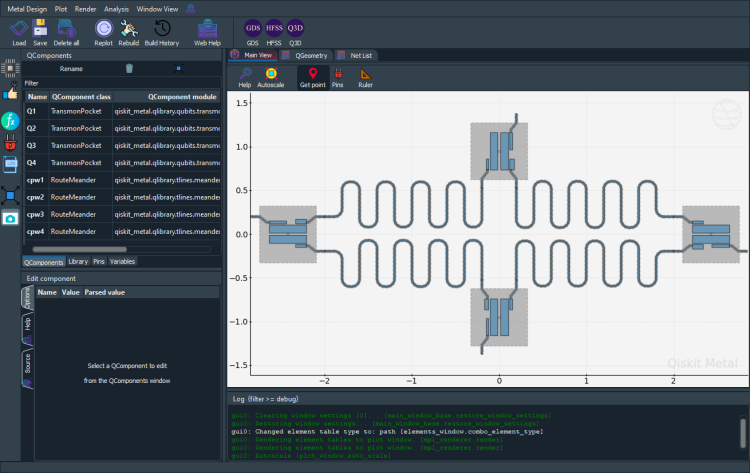

In [6]:
gui.screenshot()

## 2 Metal passes information to the simulator "q3d" to extract the capacitance matrix.


In [7]:
c1 = LOManalysis(design, "q3d")

Prepare data to pass as arguments for method run_sweep().

In [8]:
render_design_argument_qcomps = ['Q1']

render_design_argument_endcaps = [('Q1', 'readout'), ('Q1', 'bus1'),('Q1', 'bus2')]


In [9]:
# To identify the agruments that you can change.
# They will change based on the simulation software used.
c1.sim.setup

{'name': 'Setup',
 'reuse_selected_design': True,
 'reuse_setup': True,
 'freq_ghz': 5.0,
 'save_fields': False,
 'enabled': True,
 'max_passes': 15,
 'min_passes': 2,
 'min_converged_passes': 2,
 'percent_error': 0.5,
 'percent_refinement': 30,
 'auto_increase_solution_order': True,
 'solution_order': 'High',
 'solver_type': 'Iterative'}

In [10]:
# For the simulation software, if you don't want to use the default values, 
# you can update them as seen below.

# If a setup named "sweeper_q3d_setup" exists in the project, it will be deleted, 
# and a new setup will be added.
c1.sim.setup.name = "sweeper_q3d_setup"

c1.sim.setup.freq_ghz = 5.6
c1.sim.setup.max_passes = 9
c1.sim.setup.min_passes = 2
c1.sim.setup.percent_error = 0.45



We will look at modifying the pad_gap of qubit 1, to see how it impacts the anharmonicity of the qubit.

The steps will be;
- Connect to Ansys Q3D.
- Rebuild QComponents in Metal.
- Render QComponents within Q3D and setup the simulation.
- Delete/Clear the Q3D between each simulation.
- Using the capacitance matrices, LOM for each value in option_sweep is found.

#### Returns a dict and return code.  If the return code is zero, there were no errors detected.  
#### The dict has:  key = each value used to sweep, value = capacitance matrix

#### This could take minutes or hours based on the complexity of the design.



In [11]:
sweep_data, return_code = c1.run_sweep(q1.name,
                                       'pad_gap',
                                       ['20um', '30um', '40um'],
                                       render_design_argument_qcomps,
                                       render_design_argument_endcaps,
                                       design_name="GetCapacitance",
                                       box_plus_buffer=True)

INFO 05:12PM [connect_project]: Connecting to Ansys Desktop API...
INFO 05:12PM [load_ansys_project]: 	Opened Ansys App
INFO 05:12PM [load_ansys_project]: 	Opened Ansys Desktop v2021.2.0
INFO 05:12PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    J:/Ansoft/
	Project:   Project5
INFO 05:12PM [connect_design]: 	Opened active design
	Design:    GetCapacitance_q3d [Solution type: Q3D]
INFO 05:12PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 05:12PM [connect]: 	Connected to project "Project5" and design "GetCapacitance_q3d" 😀 

INFO 05:12PM [connect_design]: 	Opened active design
	Design:    GetCapacitance_q3d [Solution type: Q3D]
INFO 05:12PM [get_setup]: 	Opened setup `sweeper_q3d_setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 05:12PM [analyze]: Analyzing setup sweeper_q3d_setup
INFO 05:13PM [get_matrix]: Exporting matrix data to (C:\Users\JAGATH~1\AppData\Local\Temp\tmpasduwpn9.txt, C, , sweeper_q3d_setup:LastAdaptive, "Original", "ohm", "n

[3, 4] [5 0 1]
Predicted Values

Transmon Properties
f_Q 5.266513 [GHz]
EC 284.490474 [MHz]
EJ 13.616300 [GHz]
alpha -328.027635 [MHz]
dispersion 16.258044 [KHz]
Lq 11.995161 [nH]
Cq 68.087440 [fF]
T1 53.831750 [us]

**Coupling Properties**

tCqbus1 7.457921 [fF]
gbus1_in_MHz 108.061520 [MHz]
χ_bus1 -2.196070 [MHz]
1/T1bus1 2005.686739 [Hz]
T1bus1 79.351845 [us]

tCqbus2 -6.588291 [fF]
gbus2_in_MHz -82.021155 [MHz]
χ_bus2 -5.704388 [MHz]
1/T1bus2 655.760880 [Hz]
T1bus2 242.702711 [us]

tCqbus3 5.453079 [fF]
gbus3_in_MHz 70.106609 [MHz]
χ_bus3 -2.763400 [MHz]
1/T1bus3 295.077910 [Hz]
T1bus3 539.365834 [us]
Bus-Bus Couplings
gbus1_2 7.422809 [MHz]
gbus1_3 10.345326 [MHz]
gbus2_3 5.654427 [MHz]


INFO 05:13PM [connect_design]: 	Opened active design
	Design:    GetCapacitance_q3d [Solution type: Q3D]
INFO 05:13PM [get_setup]: 	Opened setup `sweeper_q3d_setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 05:13PM [analyze]: Analyzing setup sweeper_q3d_setup
INFO 05:14PM [get_matrix]: Exporting matrix data to (C:\Users\JAGATH~1\AppData\Local\Temp\tmpczb1qvs3.txt, C, , sweeper_q3d_setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5600000000, Maxwell, 1, False
INFO 05:14PM [get_matrix]: Exporting matrix data to (C:\Users\JAGATH~1\AppData\Local\Temp\tmpefiqwjuk.txt, C, , sweeper_q3d_setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5600000000, Maxwell, 1, False
INFO 05:14PM [get_matrix]: Exporting matrix data to (C:\Users\JAGATH~1\AppData\Local\Temp\tmpb7_eoa61.txt, C, , sweeper_q3d_setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5600000000, Maxwell, 2, False
INFO 05:14PM [get_matrix]: Exporting matrix data to (C:\Users\JAGATH~1\AppData\Local\Temp\tmpcjsjfz

[3, 4] [5 0 1]
Predicted Values

Transmon Properties
f_Q 5.462897 [GHz]
EC 307.600806 [MHz]
EJ 13.616300 [GHz]
alpha -357.287459 [MHz]
dispersion 33.474349 [KHz]
Lq 11.995161 [nH]
Cq 62.971968 [fF]
T1 31.181639 [us]

**Coupling Properties**

tCqbus1 7.545643 [fF]
gbus1_in_MHz 116.213396 [MHz]
χ_bus1 -3.378233 [MHz]
1/T1bus1 3075.191676 [Hz]
T1bus1 51.754479 [us]

tCqbus2 -6.637477 [fF]
gbus2_in_MHz -87.835128 [MHz]
χ_bus2 -11.519528 [MHz]
1/T1bus2 1457.770105 [Hz]
T1bus2 109.176984 [us]

tCqbus3 5.526346 [fF]
gbus3_in_MHz 75.520647 [MHz]
χ_bus3 -5.083082 [MHz]
1/T1bus3 571.162003 [Hz]
T1bus3 278.651140 [us]
Bus-Bus Couplings
gbus1_2 7.279458 [MHz]
gbus1_3 10.197376 [MHz]
gbus2_3 5.507283 [MHz]


INFO 05:14PM [connect_design]: 	Opened active design
	Design:    GetCapacitance_q3d [Solution type: Q3D]
INFO 05:15PM [get_setup]: 	Opened setup `sweeper_q3d_setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 05:15PM [analyze]: Analyzing setup sweeper_q3d_setup
INFO 05:16PM [get_matrix]: Exporting matrix data to (C:\Users\JAGATH~1\AppData\Local\Temp\tmp4w4vtfuv.txt, C, , sweeper_q3d_setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5600000000, Maxwell, 1, False
INFO 05:16PM [get_matrix]: Exporting matrix data to (C:\Users\JAGATH~1\AppData\Local\Temp\tmpd317tmlb.txt, C, , sweeper_q3d_setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5600000000, Maxwell, 1, False
INFO 05:16PM [get_matrix]: Exporting matrix data to (C:\Users\JAGATH~1\AppData\Local\Temp\tmpi6iwsdi9.txt, C, , sweeper_q3d_setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5600000000, Maxwell, 2, False
INFO 05:16PM [get_matrix]: Exporting matrix data to (C:\Users\JAGATH~1\AppData\Local\Temp\tmp8l_x9l

[3, 4] [5 0 1]
Predicted Values

Transmon Properties
f_Q 5.603196 [GHz]
EC 324.747859 [MHz]
EJ 13.616300 [GHz]
alpha -379.244809 [MHz]
dispersion 54.335718 [KHz]
Lq 11.995161 [nH]
Cq 59.646977 [fF]
T1 19.153152 [us]

**Coupling Properties**

tCqbus1 7.638504 [fF]
gbus1_in_MHz 122.751924 [MHz]
χ_bus1 -4.681162 [MHz]
1/T1bus1 4274.193323 [Hz]
T1bus1 37.236253 [us]

tCqbus2 -6.694974 [fF]
gbus2_in_MHz -92.444073 [MHz]
χ_bus2 -21.099340 [MHz]
1/T1bus2 3037.626181 [Hz]
T1bus2 52.394513 [us]

tCqbus3 5.592313 [fF]
gbus3_in_MHz 79.741791 [MHz]
χ_bus3 -8.315547 [MHz]
1/T1bus3 997.775951 [Hz]
T1bus3 159.509701 [us]
Bus-Bus Couplings
gbus1_2 7.162962 [MHz]
gbus1_3 10.056266 [MHz]
gbus2_3 5.376093 [MHz]


In [12]:
from pandas import DataFrame

ec_val = []
for opt_val in sweep_data.keys():
    ec_val.append([opt_val,sweep_data[opt_val]['variables']['lumped_oscillator']['EC']])

df=DataFrame(ec_val,columns = ['Sweep Value', 'Ec'])
df

,Sweep Value,Ec
0,20um,284.490474
1,30um,307.600806
2,40um,324.747859


We can grab specific values from the results as seen below;

In [13]:
sweep_data.keys()

dict_keys(['20um', '30um', '40um'])

In [14]:
# For each value of option, there is a set of data.
sweep_data['20um'].keys()

dict_keys(['option_name', 'variables', 'sim_variables'])

In [15]:
sweep_data['20um']['variables'].keys()

dict_keys(['lumped_oscillator', 'lumped_oscillator_all'])

In [16]:
sweep_data['20um']['sim_variables'].keys()

dict_keys(['sim_setup_name', 'cap_matrix', 'units', 'cap_all_passes', 'is_converged'])

A boolean flag indicating whether a sweep has converged can be obtained from the `is_converged` key within the `sim_variables`. For instance, the following code retrieves the convergence result for the sweep parameter, 20um. The convergence is extracted from the Ansys Q3D renderer.

In [17]:
sweep_data['20um']['sim_variables']['is_converged']

True

In [18]:
if return_code ==0:
    print(f'{sweep_data.keys()} \n')
    for key in sweep_data.keys():
        print(f'\nkey={key}')
        
        option_name = sweep_data[key]['option_name']
        print(f'option_name[\'{key}\'][\'option_name\']={option_name}')
        
    
        variables = sweep_data[key]['variables']
        sim_variables = sweep_data[key]['sim_variables']
        
        print(f'variables={variables}')
        print(f'sim_variables={sim_variables}')
        

        

dict_keys(['20um', '30um', '40um']) 


key=20um
option_name['20um']['option_name']=pad_gap
variables={'lumped_oscillator': {'fQ': 5.266513054956589, 'EC': 284.4904739015804, 'EJ': 13.616300010297985, 'alpha': -328.02763545951046, 'dispersion': 16.25804376029968, 'gbus': array([108.06151986, -82.02115476,  70.10660922]), 'chi_in_MHz': array([-2.19607046, -5.70438759, -2.76340023])}, 'lumped_oscillator_all':          fQ          EC       EJ       alpha dispersion  \
1  5.694647  336.214178  13.6163 -394.047036  73.540872   
2  5.597383  324.026735  13.6163 -378.317097  53.282182   
3  5.486697   310.47202  13.6163 -360.949348  36.405901   
4  5.417928  302.217736  13.6163 -350.437946  28.505987   
5  5.355959  294.888507  13.6163 -341.145422  22.741803   
6  5.311963  289.747388  13.6163 -334.649978  19.308807   
7  5.289385  287.129029  13.6163 -331.349078   17.73438   
8  5.266513  284.490474  13.6163 -328.027635  16.258044   

                                                gbus  \
1 

# READ THIS BEFORE running the cell.
This cell is to demonstrate that if you have already executed c1.sim.run(), you don't have to set up 
the environment again for c1.run_sweep().  In another words, if you don't pass updated arguments to
c1.run_sweep(), then c1.run_sweep() looks for the previous desgin arguments. 

If you pass anything more than these three arguments: qcomp_name, option_name, option_sweep ..... 
Then NOTHING will be used from previous run.  
```
c1.sim.solution_order = 'Medium'
c1.sim.auto_increase_solution_order = 'False'


c1.sim.run(components=render_design_argument_qcomps,
           open_terminations=render_design_argument_endcaps)
```

Because c1.sim.setup.run has the information from last run, this is OK.

```
sweep_data, return_code = c1.run_sweep(q1.name, 
                                        'pad_gap', 
                                        ['20um', '30um', '40um'])
```

In [19]:
c1.sim.close()

In [20]:
# Uncomment next line if you would like to close the gui
gui.main_window.close()

True